In [1]:
from tensorflow.keras.datasets import mnist
import sys

from tqdm import tqdm
from torch import optim
import torch
import matplotlib.pyplot as plt


from vae import VAE

import numpy as np

2024-12-17 12:52:48.390069: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(len(X_train), -1) / 255
X_test = X_test.reshape(len(X_test), -1) / 255

y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)
X_train = torch.Tensor(X_train)
X_test = torch.Tensor(X_test)
X_train.shape, X_test.shape

(torch.Size([60000, 784]), torch.Size([10000, 784]))

# Part 1. VAE
The idea: we want to learn some latent representation of data using MLE (maximal lieklihood estimate) but this is complicated and we can only use ELBO (evidence lower bound) and do some manipulation to the final loss.   
$E_{x\sim p_{data}}\ln p_{data}(x) \ge E_{q_\phi(z|x)}\ln p(x|z,\theta) - D_{KL}(q_\phi(z|x) || p(z))$   
Usings Gaussian the loss can be simplified to (https://arxiv.org/pdf/1312.6114)
$L_{\theta, \phi}(x)=E_{q_\phi(z|x)}|| x- D_\theta(z)||^2_2 + 0.5 \sum^J_j(1 + \ln \sigma_j^2 - \mu_j^2-\sigma^2_j)$  
Where $ D_\theta(z)$ is an otput of decoder, J - the latent size. Note! 
The first term is often called as a reconstruction loss. Can use MSE / BCE for reconstuction
Practically speaking,  
1. We for a data point $x_i$ we map it to $z_i$ using $z_i = q_\phi(z|x_i)$. The encoder part. 
2. Sample using $z_i$ from gaussian
3. Reconstruct $x_i$ from the sample using $p(x|z_i,\theta)$. The decoder part.

In [3]:
N_EPOCHS = 10

input_dims = X_train.shape[-1]
output_dims = X_train.shape[-1]

batch_size = 128
hid_dims = 300
n_hid_layers = 1
latent_dims = 2

train_loader = torch.utils.data.DataLoader(list(zip(X_train, y_train)), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(list(zip(X_test, y_test)), batch_size=batch_size, shuffle=False)

In [4]:
# mu, logvar = vae.encode(data, labels)

# z = vae._reparametrization_trick(mu, logvar)
# z.shape

3393.06005859375, rec_loss=3208.78466796875, kl_loss=184.27548217773438: 100%|██████████| 10/10 [00:37<00:00,  3.78s/it]


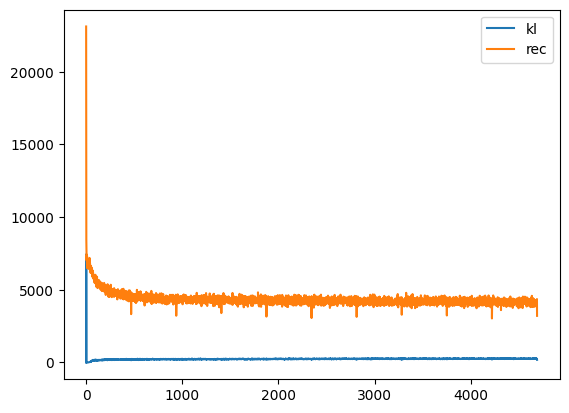

In [5]:
# BCE reconstuction loss 
vae = VAE(input_dim=input_dims,
          hidden_dim=hid_dims,
          output_dim=output_dims,
          latent_dim=latent_dims,
          n_hid_layers=n_hid_layers,
          n_emb=10,
          emb_dim=2,
          )

opt = optim.Adam(vae.parameters(), lr=0.01)
rec_loss_hist, kl_loss_hist = [], []



for _ in (pbar := tqdm(range(N_EPOCHS))):
    for batch_idx, (data, labels) in enumerate(train_loader):
        opt.zero_grad()
        data_hat, mu, logvar = vae(data, labels)
        loss, rec_loss, kl_loss = vae.loss_mse(data, data_hat, mu, logvar, 1)
        rec_loss = rec_loss.detach().cpu().item()
        kl_loss = kl_loss.detach().cpu().item()
        loss.backward()
        opt.step()
        rec_loss_hist.append(rec_loss)
        kl_loss_hist.append(kl_loss)
    pbar.set_description(f'{loss.detach().cpu().item():=}, {rec_loss=}, {kl_loss=}')

plt.plot(kl_loss_hist, label='kl')
plt.plot(rec_loss_hist, label='rec')
plt.legend();
 

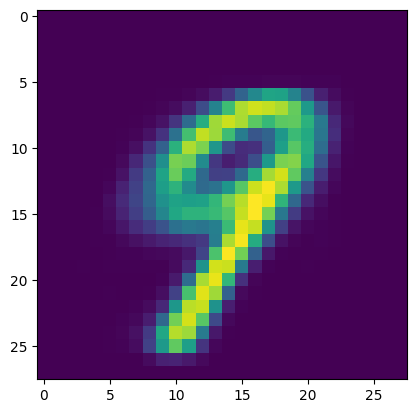

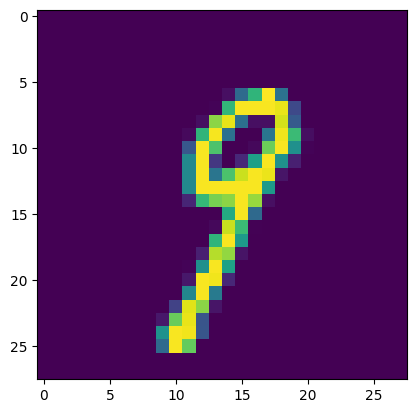

In [6]:
ind = 4
plt.imshow(data_hat[ind].detach().numpy().reshape(28, 28))
plt.show()
plt.imshow(data[ind].detach().numpy().reshape(28, 28))

15845.62890625, rec_loss=15626.619140625, kl_loss=219.0093994140625: 100%|██████████| 10/10 [00:45<00:00,  4.58s/it]   


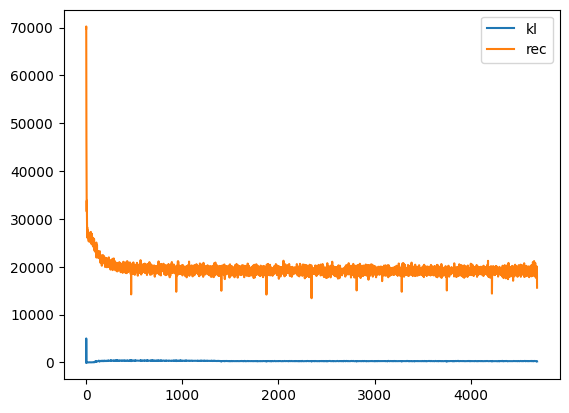

In [7]:
# MSE reconstuction loss 
vae = VAE(input_dim=input_dims,
          hidden_dim=hid_dims,
          output_dim=output_dims,
          latent_dim=latent_dims,
          n_hid_layers=n_hid_layers,
          n_emb=10,
          emb_dim=2,
          )

opt = optim.Adam(vae.parameters(), lr=0.01)
rec_loss_hist, kl_loss_hist = [], []



for _ in (pbar := tqdm(range(N_EPOCHS))):
    for batch_idx, (data, labels) in enumerate(train_loader):
        opt.zero_grad()
        data_hat, mu, logvar = vae(data, labels)
        loss, rec_loss, kl_loss = vae.loss_bce(data, data_hat, mu, logvar, 1)
        rec_loss = rec_loss.detach().cpu().item()
        kl_loss = kl_loss.detach().cpu().item()
        loss.backward()
        opt.step()
        rec_loss_hist.append(rec_loss)
        kl_loss_hist.append(kl_loss)
    pbar.set_description(f'{loss.detach().cpu().item():=}, {rec_loss=}, {kl_loss=}')

plt.plot(kl_loss_hist, label='kl')
plt.plot(rec_loss_hist, label='rec')
plt.legend();


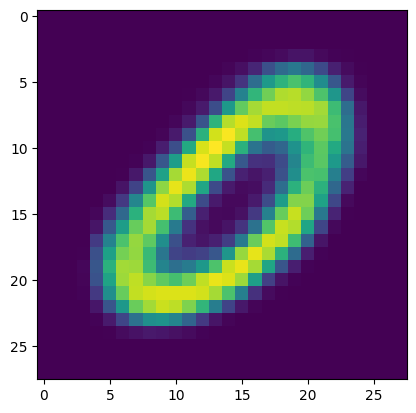

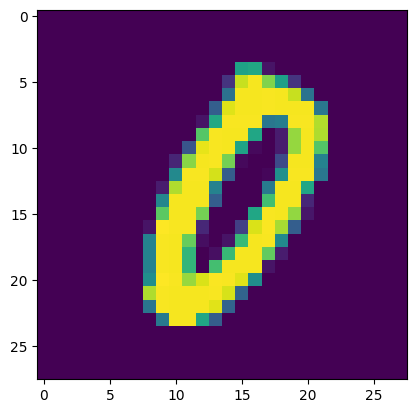

In [8]:
ind = 5
plt.imshow(data_hat[ind].detach().numpy().reshape(28, 28))
plt.show()
plt.imshow(data[ind].detach().numpy().reshape(28, 28))

14379562.0, rec_loss=14377532.0, kl_loss=2030.4652099609375: 100%|██████████| 10/10 [00:18<00:00,  1.88s/it]


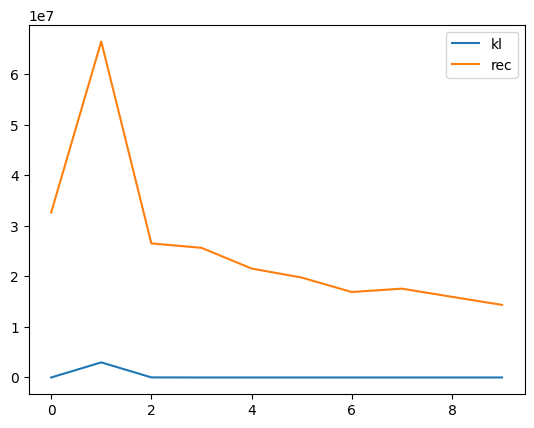

In [9]:
# Big bartch -> nothing is learning 

train_loader = torch.utils.data.DataLoader(list(zip(X_train, y_train)), batch_size=60_000, shuffle=True)

vae = VAE(input_dim=input_dims,
          hidden_dim=hid_dims,
          output_dim=output_dims,
          latent_dim=latent_dims,
          n_hid_layers=n_hid_layers,
          n_emb=10,
          emb_dim=2,
          )

opt = optim.Adam(vae.parameters(), lr=0.01)
rec_loss_hist, kl_loss_hist = [], []



for _ in (pbar := tqdm(range(N_EPOCHS))):
    for batch_idx, (data, labels) in enumerate(train_loader):
        opt.zero_grad()
        data_hat, mu, logvar = vae(data, labels)
        loss, rec_loss, kl_loss = vae.loss_bce(data, data_hat, mu, logvar, 1)
        rec_loss = rec_loss.detach().cpu().item()
        kl_loss = kl_loss.detach().cpu().item()
        loss.backward()
        opt.step()
        rec_loss_hist.append(rec_loss)
        kl_loss_hist.append(kl_loss)
    pbar.set_description(f'{loss.detach().cpu().item():=}, {rec_loss=}, {kl_loss=}')

plt.plot(kl_loss_hist, label='kl')
plt.plot(rec_loss_hist, label='rec')
plt.legend();


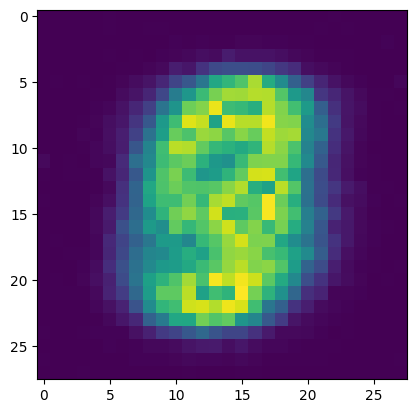

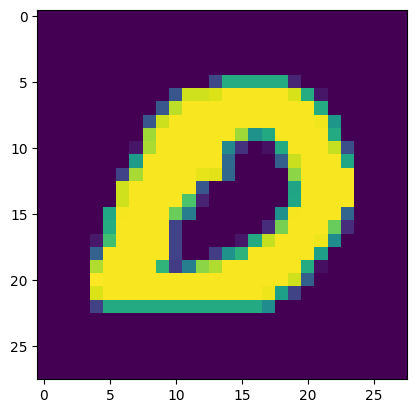

In [10]:
# Something close to average picture here.
ind = 2
plt.imshow(data_hat[ind].detach().numpy().reshape(28, 28))
plt.show()
plt.imshow(data[ind].detach().numpy().reshape(28, 28))

## Let's check sampling and reconstruction

13400.244140625, rec_loss=13015.0244140625, kl_loss=385.219482421875: 100%|██████████| 20/20 [01:46<00:00,  5.31s/it]   


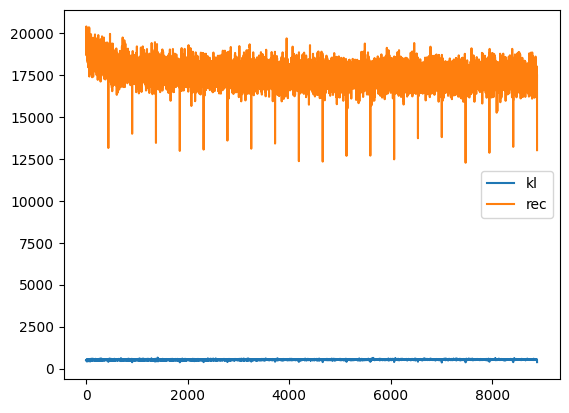

In [11]:
train_loader = torch.utils.data.DataLoader(list(zip(X_train, y_train)), batch_size=128, shuffle=True)
N_EPOCHS = 20
batch_size = 128
hid_dims = 300
n_hid_layers = 2
latent_dims = 10


vae = VAE(input_dim=input_dims,
          hidden_dim=hid_dims,
          output_dim=output_dims,
          latent_dim=latent_dims,
          n_hid_layers=n_hid_layers,
          n_emb=10,
          emb_dim=2,
          )

opt = optim.Adam(vae.parameters(), lr=0.01)
rec_loss_hist, kl_loss_hist = [], []



for _ in (pbar := tqdm(range(N_EPOCHS))):
    for batch_idx, (data, labels) in enumerate(train_loader):
        opt.zero_grad()
        data_hat, mu, logvar = vae(data, labels)
        loss, rec_loss, kl_loss = vae.loss_bce(data, data_hat, mu, logvar, 1)
        loss, rec_loss, kl_loss = vae.loss_bce(data, data_hat, mu, logvar, 1)
        rec_loss = rec_loss.detach().cpu().item()
        kl_loss = kl_loss.detach().cpu().item()
        loss.backward()
        opt.step()
        rec_loss_hist.append(rec_loss)
        kl_loss_hist.append(kl_loss)
    pbar.set_description(f'{loss.detach().cpu().item():=}, {rec_loss=}, {kl_loss=}')

plt.plot(kl_loss_hist[500:], label='kl')
plt.plot(rec_loss_hist[500:], label='rec')
plt.legend();


/var/folders/rm/52snk1ts6lv7smxnr467kzbx2hmb6p/T/ipykernel_21511/4228950652.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


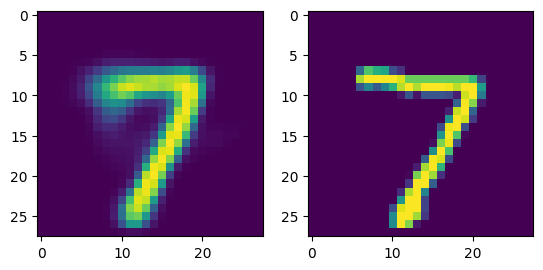

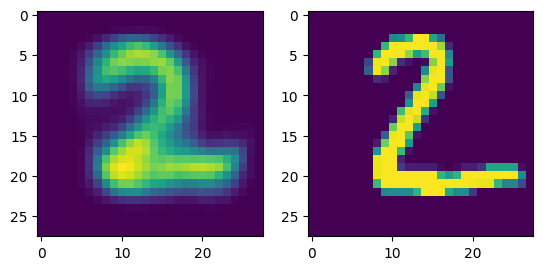

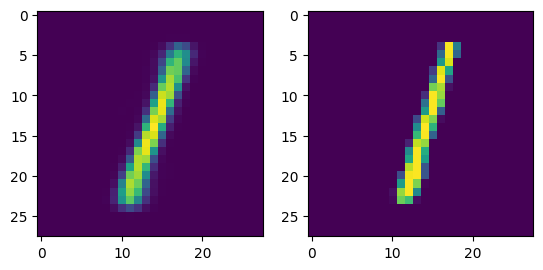

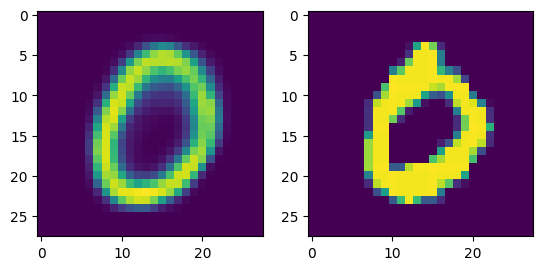

In [12]:
# Let's check reconstructio loss here

n_samples = 4
test_samples, labels = next(iter(test_loader))

with torch.no_grad():
    recon, _, _ = vae(test_samples, labels)


for i in range(n_samples):
    fig, axs = plt.subplots(1, 2)    
    axs[0].imshow(recon[i].numpy().reshape(28, 28))
    axs[1].imshow(test_samples[i].numpy().reshape(28, 28))
    fig.show()

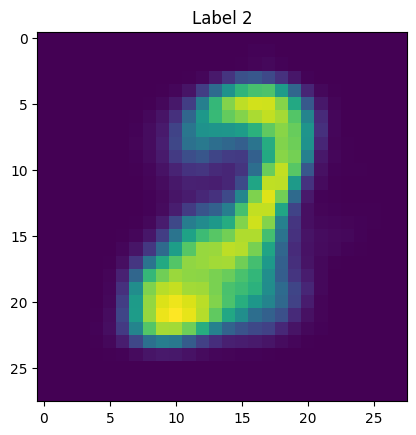

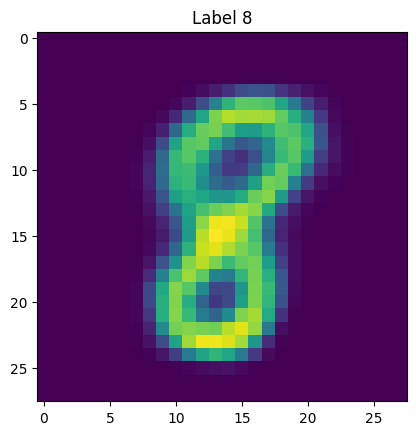

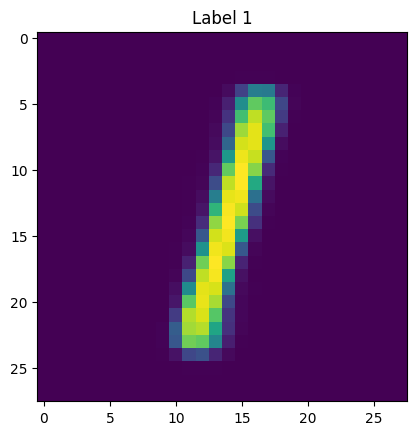

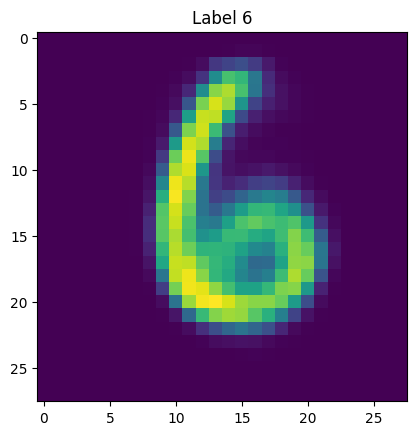

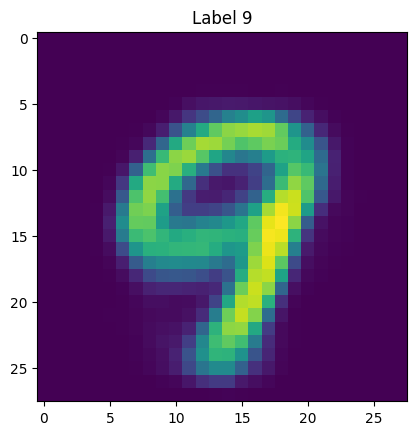

In [13]:
# Let's sample some numbpers 
n_samples = 5

with torch.no_grad():
    labels =  torch.randint(0, 10, (n_samples, ))
    samples = vae.decode(torch.randn(n_samples, latent_dims), labels)
for i in range(n_samples):
    plt.title(f'Label {labels[i].detach().item()}')
    plt.imshow(samples[i].numpy().reshape(28, 28))
    plt.show()

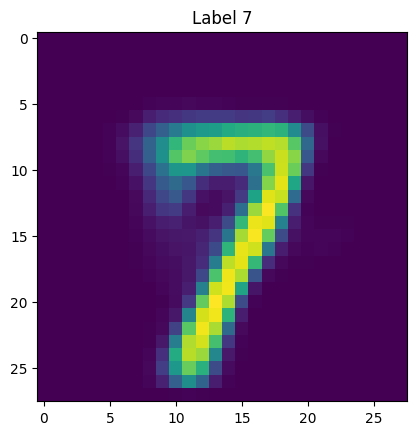

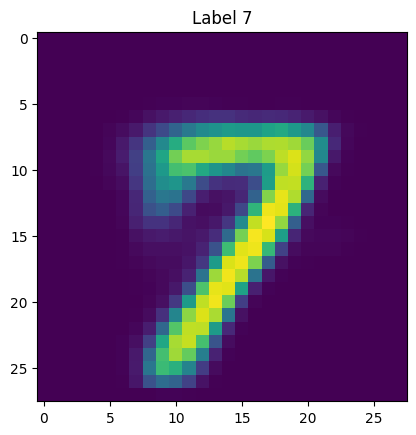

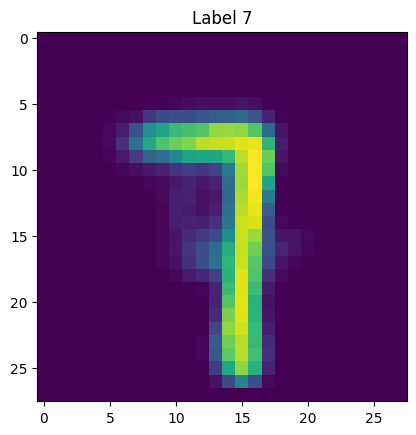

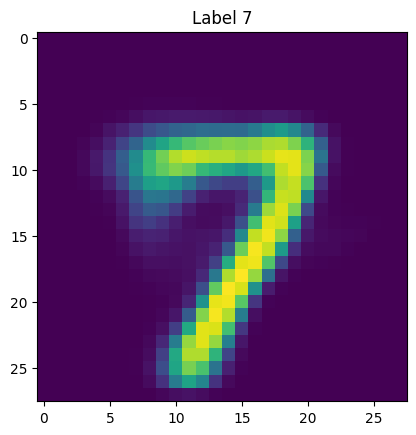

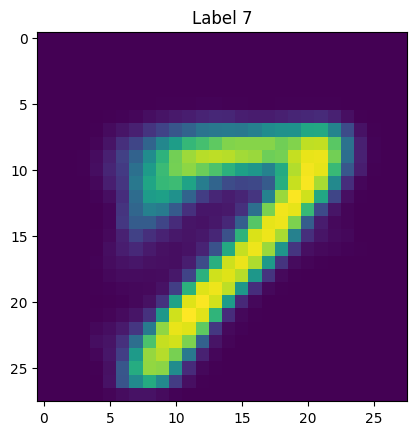

In [24]:
n_samples = 5

with torch.no_grad():
    labels =  7 * torch.ones(n_samples, dtype=int)
    samples = vae.decode(torch.randn(n_samples, latent_dims), labels)
for i in range(n_samples):
    plt.title(f'Label {labels[i].detach().item()}')
    plt.imshow(samples[i].numpy().reshape(28, 28))
    plt.show()

## Let's compression part

  0%|          | 0/20 [00:00<?, ?it/s]

3466.5830078125, rec_loss=3274.789794921875, kl_loss=191.79319763183594: 100%|██████████| 20/20 [02:20<00:00,  7.00s/it]  


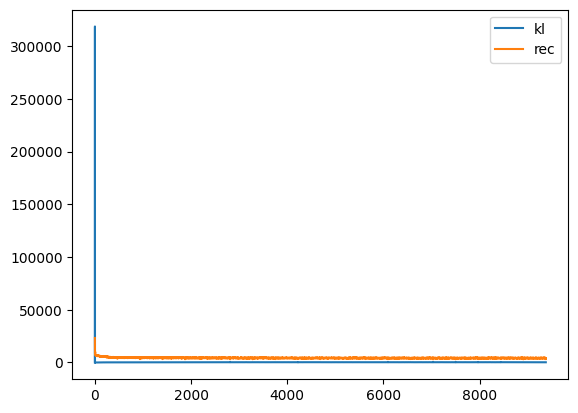

In [19]:
# Compress to 2 dims

N_EPOCHS = 20
batch_size = 128
hid_dims = 300
n_hid_layers = 3
latent_dims = 2

# BCE reconstuction loss 
vae = VAE(input_dim=input_dims,
          hidden_dim=hid_dims,
          output_dim=output_dims,
          latent_dim=latent_dims,
          n_hid_layers=n_hid_layers,
          n_emb=10,
          emb_dim=2,
          )

opt = optim.Adam(vae.parameters(), lr=0.01)
rec_loss_hist, kl_loss_hist = [], []



for _ in (pbar := tqdm(range(N_EPOCHS))):
    for batch_idx, (data, labels) in enumerate(train_loader):
        opt.zero_grad()
        data_hat, mu, logvar = vae(data, labels)
        loss, rec_loss, kl_loss = vae.loss_mse(data, data_hat, mu, logvar, 1)
        rec_loss = rec_loss.detach().cpu().item()
        kl_loss = kl_loss.detach().cpu().item()
        loss.backward()
        opt.step()
        rec_loss_hist.append(rec_loss)
        kl_loss_hist.append(kl_loss)
    pbar.set_description(f'{loss.detach().cpu().item():=}, {rec_loss=}, {kl_loss=}')

plt.plot(kl_loss_hist, label='kl')
plt.plot(rec_loss_hist, label='rec')
plt.legend();
 

/var/folders/rm/52snk1ts6lv7smxnr467kzbx2hmb6p/T/ipykernel_14556/2495115428.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


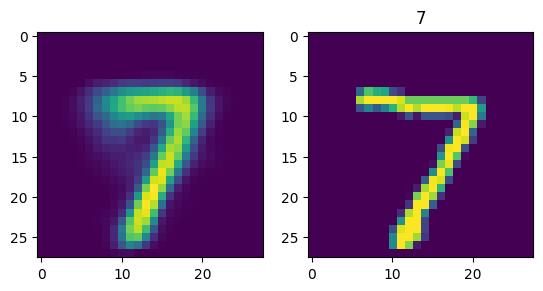

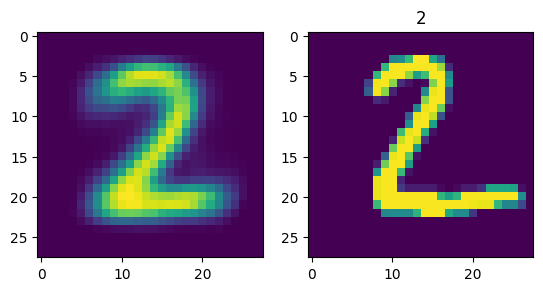

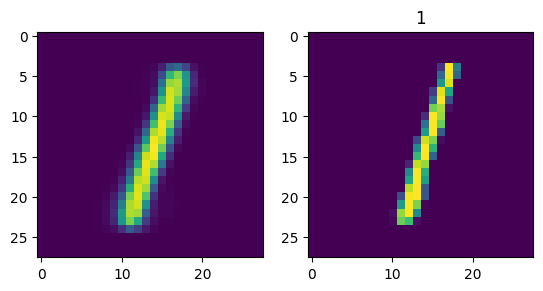

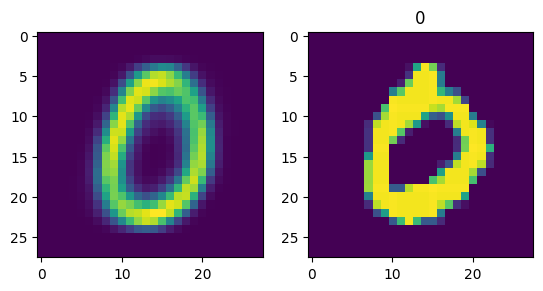

In [ ]:
# Let's check reconstructio loss here


n_samples = 4
test_samples, labels = next(iter(test_loader))

with torch.no_grad():
    recon, _, _ = vae(test_samples, labels)


for i in range(n_samples):
    fig, axs = plt.subplots(1, 2)    
    plt.title(labels[i].detach().item())
    axs[0].imshow(recon[i].numpy().reshape(28, 28))
    axs[1].imshow(test_samples[i].numpy().reshape(28, 28))
    fig.show()


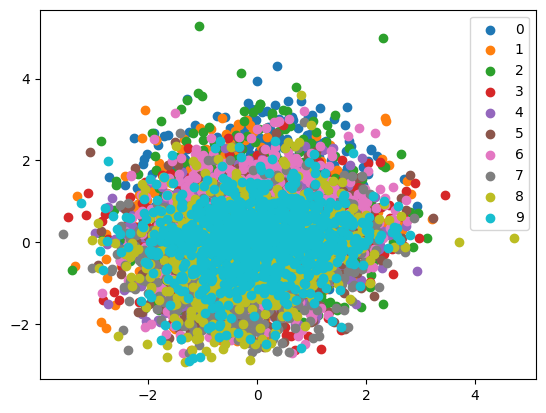

In [24]:
latent_reps = []
with torch.no_grad():
    for batch_idx, (data, labels) in enumerate(test_loader):
        mu, logvar = vae.encode(data, labels)
        latent_reps.append(vae._reparametrization_trick(mu, logvar).numpy())

X_test_latent = np.concatenate(latent_reps)
for i in range(10):
    samples_to_plot = X_test_latent[y_test == i]
    plt.scatter(samples_to_plot[:, 0], samples_to_plot[:, 1], label=i)
plt.legend()